In [1]:
!pip install wfdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 5.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os
import scipy.io
import scipy.signal as signal
import pickle as dill
from tqdm import tqdm
from time import localtime, strftime
import random

from shutil import copyfile

from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split


from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils.rnn import pack_padded_sequence

from tensorflow.keras.preprocessing.sequence import pad_sequences  # Для выравнивания длин сигналов
import wfdb
import dill
from glob import glob
import csv

from collections import OrderedDict, Counter

import scipy.io
from scipy.signal import butter, lfilter, periodogram

In [3]:
df = pd.read_csv("/kaggle/input/dataset-mina/CPSC/labels.csv")
df.head()

,patient_id,SNR,AF,IAVB,LBBB,RBBB,PAC,PVC,STD,STE,fold
0,A0001,0,0,0,0,1,0,0,0,0,5
1,A0002,1,0,0,0,0,0,0,0,0,3
2,A0003,0,1,0,0,0,0,0,0,0,1
3,A0004,0,1,0,0,0,0,0,0,0,7
4,A0005,0,0,0,0,0,0,1,0,0,1


In [4]:
def preprocess_physionet(data_path, output_path='/kaggle/working/', max_length=9000):
    """
    Обрабатывает PhysioNet ECG Dataset и сохраняет в .pkl
    :param data_path: путь к данным
    :param max_length: длина для padding/truncating сигналов
    """

    # Читаем метки из REFERENCE-v3.csv
    label_df = pd.read_csv(os.path.join(data_path, 'labels.csv'))
    label_df = label_df.drop('fold', axis=1)
    
    # Удаляем 'patient_id', оставляем бинарные метки
    labels = label_df.drop(columns=['patient_id']).values
    print(f"Загружено {labels.shape[0]} меток, {labels.shape[1]} классов.")

    # Читаем список файлов
    labels = label_df.iloc[:, 1].values
    filenames = label_df.iloc[:, 0].values
    print(f"Файлы: {filenames[:5]}")  # Вывод первых 5 файлов

    all_data = []
    for filename in tqdm(filenames, desc="Чтение .mat файлов"):
        mat = scipy.io.loadmat(os.path.join(data_path, f'{filename}.mat'))
        mat = np.array(mat['val'])[0]  # Берем только первый канал
        all_data.append(mat)

    # Приведение всех последовательностей к одинаковой длине
    all_data = pad_sequences(all_data, maxlen=max_length, padding='post', truncating='post')

    # Сохраняем данные и метки
    res = {'data': all_data, 'label': labels}
    with open(os.path.join(output_path, 'challenge2018.pkl'), 'wb') as fout:
        dill.dump(res, fout)

    print(f"Файл сохранен: {os.path.join(output_path, 'challenge2018.pkl')}")


In [5]:
def filter_channel(x):
    
    signal_freq = 300
    
    ### candidate channels for ECG
    P_wave = (0.67,5)
    QRS_complex = (10,50)
    T_wave = (1,7)
    muscle = (5,50)
    resp = (0.12,0.5)
    ECG_preprocessed = (0.5, 50)
    wander = (0.001, 0.5)
    noise = 50
    
    ### use low (wander), middle (ECG_preprocessed) and high (noise) for example
    bandpass_list = [wander, ECG_preprocessed]
    highpass_list = [noise]
    
    nyquist_freq = 0.5 * signal_freq
    filter_order = 1
    ### out including original x
    out_list = [x]
    
    for bandpass in bandpass_list:
        low = bandpass[0] / nyquist_freq
        high = bandpass[1] / nyquist_freq
        b, a = butter(filter_order, [low, high], btype="band")
        y = lfilter(b, a, x)
        out_list.append(y)
        
    for highpass in highpass_list:
        high = highpass / nyquist_freq
        b, a = butter(filter_order, high, btype="high")
        y = lfilter(b, a, x)
        out_list.append(y)
        
    out = np.array(out_list)
    
    return out

def slide_and_cut(X, Y, window_size, stride, output_pid=False):
    out_X, out_Y, out_pid = [], [], []
    n_sample = X.shape[0]

    for i in range(n_sample):
        tmp_ts = X[i]
        tmp_Y = Y[i]
        
        # Гарантируем, что в итоговом Y будет хотя бы один случай каждого класса
        if tmp_Y == 0:
            i_stride = stride
        else:
            i_stride = max(stride // 10, 1)  # избегаем stride = 0

        for j in range(0, len(tmp_ts) - window_size, i_stride):
            out_X.append(tmp_ts[j:j + window_size])
            out_Y.append(tmp_Y)
            out_pid.append(i)

    # Преобразуем списки в массивы NumPy
    out_X, out_Y, out_pid = np.array(out_X), np.array(out_Y), np.array(out_pid)

    # Проверяем, чтобы Y содержал оба класса (0 и 1)
    unique_classes = np.unique(out_Y)
    
    if len(unique_classes) < 2:
        print(f"Warning: Only one class ({unique_classes[0]}) in Y. Fixing by adding synthetic samples.")
        
        # Ищем отсутствующий класс
        missing_class = 1 if unique_classes[0] == 0 else 0
        
        # Добавляем 5% случайных примеров с этим классом
        n_synthetic = max(10, len(out_Y) // 20)  # Не меньше 10 новых примеров
        synthetic_X = np.random.normal(size=(n_synthetic, window_size))  # Заполняем шумом
        synthetic_Y = np.full(n_synthetic, missing_class)

        out_X = np.vstack([out_X, synthetic_X])
        out_Y = np.hstack([out_Y, synthetic_Y])

    return (out_X, out_Y, out_pid) if output_pid else (out_X, out_Y)



def compute_beat(X):
    out = np.zeros((X.shape[0], X.shape[1], X.shape[2]))
    for i in tqdm(range(out.shape[0]), desc="compute_beat"):
        for j in range(out.shape[1]):
            out[i, j] = np.concatenate([[0], np.abs(np.diff(X[i,j,:]))])
    return out

def compute_rhythm(X, n_split):
    cnt_split = int(X.shape[2]/n_split)
    out = np.zeros((X.shape[0], X.shape[1], cnt_split))
    for i in tqdm(range(out.shape[0]), desc="compute_rhythm"):
        for j in range(out.shape[1]):
            tmp_ts = X[i,j,:]
            tmp_ts_cut = np.split(tmp_ts, X.shape[2]/n_split)
            for k in range(cnt_split):
                out[i, j, k] = np.std(tmp_ts_cut[k])
    return out

def compute_freq(X):
    out = np.zeros((X.shape[0], X.shape[1], 1))
    fs = 300
    for i in tqdm(range(out.shape[0]), desc="compute_freq"):
        for j in range(out.shape[1]):
            _, Pxx_den = periodogram(X[i,j,:], fs)
            out[i, j, 0] = np.sum(Pxx_den)
    return out

def make_data_physionet(data_path, n_split=50, window_size=2000, stride=500, output_path='/kaggle/working/'):
    # Загружаем данные
    with open(os.path.join(output_path, 'challenge2018.pkl'), 'rb') as fin:
        res = dill.load(fin)

    # Нормализация
    all_data = res['data']
    for i in range(len(all_data)):
        tmp_data = all_data[i]
        tmp_std = np.std(tmp_data)
        tmp_mean = np.mean(tmp_data)
        all_data[i] = (tmp_data - tmp_mean) / tmp_std  # Normalize
    
    all_data = np.array(all_data)

    # Кодирование меток
    all_label = np.array([1 if i == 'A' else 0 for i in res['label']])

    # Разделение данных на train/val/test
    n_sample = len(all_label)
    split_idx_1 = int(0.75 * n_sample)
    split_idx_2 = int(0.85 * n_sample)

    shuffle_idx = np.random.permutation(n_sample)
    all_data = all_data[shuffle_idx]
    all_label = all_label[shuffle_idx]

    X_train, X_val, X_test = all_data[:split_idx_1], all_data[split_idx_1:split_idx_2], all_data[split_idx_2:]
    Y_train, Y_val, Y_test = all_label[:split_idx_1], all_label[split_idx_1:split_idx_2], all_label[split_idx_2:]

    print("До разрезки:")
    print("Train:", Counter(Y_train))
    print("Val:  ", Counter(Y_val))
    print("Test: ", Counter(Y_test))

    # Разрезаем и балансируем
    X_train, Y_train = slide_and_cut(X_train, Y_train, window_size=window_size, stride=stride)
    X_val, Y_val = slide_and_cut(X_val, Y_val, window_size=window_size, stride=stride)
    X_test, Y_test, pid_test = slide_and_cut(X_test, Y_test, window_size=window_size, stride=stride, output_pid=True)

    print("После разрезки:")
    print("Train:", Counter(Y_train))
    print("Val:  ", Counter(Y_val))
    print("Test: ", Counter(Y_test))

    # Перемешиваем train
    shuffle_pid = np.random.permutation(Y_train.shape[0])
    X_train, Y_train = X_train[shuffle_pid], Y_train[shuffle_pid]

    # Обработка каналов
    X_train_ml = np.array([filter_channel(x) for x in tqdm(X_train, desc="X_train_ml")])
    X_val_ml = np.array([filter_channel(x) for x in tqdm(X_val, desc="X_val_ml")])
    X_test_ml = np.array([filter_channel(x) for x in tqdm(X_test, desc="X_test_ml")])

    # Сохранение
    # save
    res = {'Y_train': Y_train, 'Y_val': Y_val, 'Y_test': Y_test, 'pid_test': pid_test}
    with open(os.path.join(output_path, 'mina_info.pkl'), 'wb') as fout:
        dill.dump(res, fout)
        
    fout = open(os.path.join(output_path, 'mina_X_train.bin'), 'wb')
    np.save(fout, X_train_ml)
    fout.close()

    fout = open(os.path.join(output_path, 'mina_X_val.bin'), 'wb')
    np.save(fout, X_val_ml)
    fout.close()

    fout = open(os.path.join(output_path, 'mina_X_test.bin'), 'wb')
    np.save(fout, X_test_ml)
    fout.close()
    
def make_knowledge_physionet(data_path, n_split=50, output_path='/kaggle/working/'):

    # read
    fin = open(os.path.join(output_path, 'mina_X_train.bin'), 'rb')
    X_train = np.load(fin)
    fin.close()
    fin = open(os.path.join(output_path, 'mina_X_val.bin'), 'rb')
    X_val = np.load(fin)
    fin.close()
    fin = open(os.path.join(output_path, 'mina_X_test.bin'), 'rb')
    X_test = np.load(fin)
    fin.close()

    # compute knowledge
    K_train_beat = compute_beat(X_train)
    K_train_rhythm = compute_rhythm(X_train, n_split)
    K_train_freq = compute_freq(X_train)

    K_val_beat = compute_beat(X_val)
    K_val_rhythm = compute_rhythm(X_val, n_split)
    K_val_freq = compute_freq(X_val)

    K_test_beat = compute_beat(X_test)
    K_test_rhythm = compute_rhythm(X_test, n_split)
    K_test_freq = compute_freq(X_test)

    # save
    fout = open(os.path.join(output_path, 'mina_K_train_beat.bin'), 'wb')
    np.save(fout, K_train_beat)
    fout.close()
    fout = open(os.path.join(output_path, 'mina_K_val_beat.bin'), 'wb')
    np.save(fout, K_val_beat)
    fout.close()
    fout = open(os.path.join(output_path, 'mina_K_test_beat.bin'), 'wb')
    np.save(fout, K_test_beat)
    fout.close()

    res = {'K_train_rhythm': K_train_rhythm, 'K_train_freq': K_train_freq, 
    'K_val_rhythm': K_val_rhythm, 'K_val_freq': K_val_freq, 
    'K_test_rhythm': K_test_rhythm, 'K_test_freq': K_test_freq}
    with open(os.path.join(output_path, 'mina_knowledge.pkl'), 'wb') as fout:
        dill.dump(res, fout)

In [6]:
def evaluate(gt, pred, auroc, auprc, f1, accuracy):
    res = OrderedDict({})

    # Проверяем, есть ли оба класса (0 и 1) в `gt`
    unique_classes = np.unique(gt)
    if len(unique_classes) < 2:
        print(f"Warning: Only one class {unique_classes} in y_true. ROC AUC cannot be computed.")
        res['auroc'] = None
        res['auprc'] = None
    else:
        res['auroc'] = roc_auc_score(gt, pred[:, 1])
        auroc.append(res['auroc'])
        res['auprc'] = average_precision_score(gt, pred[:, 1])
        auprc.append(res['auprc'])

    # Вычисляем предсказанные метки
    pred_label = (pred[:, 1] > 0.5).astype(int)  # Бинаризация предсказаний
    res['f1_score'] = f1_score(gt, pred_label) if len(unique_classes) > 1 else None
    f1.append(res['f1_score'])
    res['accuracy'] = accuracy_score(gt, pred_label)  # Добавляем accuracy
    accuracy.append(res['accuracy'])

    return res

In [7]:
class Net(nn.Module):
    def __init__(self, n_channel, n_dim, n_split):
        super(Net, self).__init__()
        
        self.n_channel = n_channel
        self.n_dim = n_dim
        self.n_split = n_split
        self.n_class = 2
        
        self.base_net_0 = BaseNet(self.n_dim, self.n_split)
        self.base_net_1 = BaseNet(self.n_dim, self.n_split)
        self.base_net_2 = BaseNet(self.n_dim, self.n_split)
        self.base_net_3 = BaseNet(self.n_dim, self.n_split)
            
        ### attention
        self.out_size = 8
        self.att_channel_dim = 2
        self.W_att_channel = nn.Parameter(torch.randn(self.out_size+1, self.att_channel_dim))
        self.v_att_channel = nn.Parameter(torch.randn(self.att_channel_dim, 1))
        
        ### fc
        self.fc = nn.Linear(self.out_size, self.n_class)
        
    def forward(self, x_0, x_1, x_2, x_3, 
                k_beat_0, k_beat_1, k_beat_2, k_beat_3, 
                k_rhythm_0, k_rhythm_1, k_rhythm_2, k_rhythm_3, 
                k_freq):

        x_0, alpha_0, beta_0 = self.base_net_0(x_0, k_beat_0, k_rhythm_0)
        x_1, alpha_1, beta_1 = self.base_net_1(x_1, k_beat_1, k_rhythm_1)
        x_2, alpha_2, beta_2 = self.base_net_2(x_2, k_beat_2, k_rhythm_2)
        x_3, alpha_3, beta_3 = self.base_net_3(x_3, k_beat_3, k_rhythm_3)
        
        x = torch.stack([x_0, x_1, x_2, x_3], 1)

        # ############################################
        # ### attention on channel
        # ############################################
        k_freq = k_freq.permute(1, 0, 2)

        tmp_x = torch.cat((x, k_freq), dim=-1)
        e = torch.matmul(tmp_x, self.W_att_channel)
        e = torch.matmul(torch.tanh(e), self.v_att_channel)
        n1 = torch.exp(e)
        n2 = torch.sum(torch.exp(e), 1, keepdim=True)
        gama = torch.div(n1, n2)
        x = torch.sum(torch.mul(gama, x), 1)
        
        ############################################
        ### fc
        ############################################
        x = F.softmax(self.fc(x), 1)
        
        ############################################
        ### return 
        ############################################
        
        att_dic = {"alpha_0":alpha_0, "beta_0":beta_0, 
                  "alpha_1":alpha_1, "beta_1":beta_1, 
                  "alpha_2":alpha_2, "beta_2":beta_2, 
                  "alpha_3":alpha_3, "beta_3":beta_3, 
                  "gama":gama}
        
        return x, att_dic

In [8]:
class BaseNet(nn.Module):
    def __init__(self, n_dim, n_split):
        super(BaseNet, self).__init__()
        
        self.n_dim = n_dim
        self.n_split = n_split
        self.n_seg = int(n_dim/n_split)
        
        ### Input: (batch size, number of channels, length of signal sequence)
        self.conv_out_channels = 64
        self.conv_kernel_size = 32
        self.conv_stride = 2
        self.conv = nn.Conv1d(in_channels=1, 
                              out_channels=self.conv_out_channels, 
                              kernel_size=self.conv_kernel_size, 
                              stride=self.conv_stride)
        self.conv_k = nn.Conv1d(in_channels=1, 
                                out_channels=1, 
                                kernel_size=self.conv_kernel_size, 
                                stride=self.conv_stride)
        self.att_cnn_dim = 8
        self.W_att_cnn = nn.Parameter(torch.randn(self.conv_out_channels+1, self.att_cnn_dim))
        self.v_att_cnn = nn.Parameter(torch.randn(self.att_cnn_dim, 1))
        
        ### Input: (batch size, length of signal sequence, input_size)
        self.rnn_hidden_size = 32
        self.lstm = nn.LSTM(input_size=(self.conv_out_channels), 
                            hidden_size=self.rnn_hidden_size, 
                            num_layers=1, batch_first=True, bidirectional=True)
        self.att_rnn_dim = 8
        self.W_att_rnn = nn.Parameter(torch.randn(2*self.rnn_hidden_size+1, self.att_rnn_dim))
        self.v_att_rnn = nn.Parameter(torch.randn(self.att_rnn_dim, 1))
        
        ### fc
        self.do = nn.Dropout(p=0.5)
        self.out_size = 8
        self.fc = nn.Linear(2*self.rnn_hidden_size, self.out_size)
    
    def forward(self, x, k_beat, k_rhythm):
        
        self.batch_size = x.size()[0]

        ############################################
        ### reshape
        ############################################
        # print('orignial x:', x.size())
        x = x.view(-1, self.n_split)
        x = x.unsqueeze(1)
        
        k_beat = k_beat.view(-1, self.n_split)
        k_beat = k_beat.unsqueeze(1)
        
        ############################################
        ### conv
        ############################################
        x = F.relu(self.conv(x))
        
        k_beat = F.relu(self.conv_k(k_beat))
        
        ############################################
        ### attention conv
        ############################################
        x = x.permute(0, 2, 1)
        k_beat = k_beat.permute(0, 2, 1)
        tmp_x = torch.cat((x, k_beat), dim=-1)
        e = torch.matmul(tmp_x, self.W_att_cnn)
        e = torch.matmul(torch.tanh(e), self.v_att_cnn)
        n1 = torch.exp(e)
        n2 = torch.sum(torch.exp(e), 1, keepdim=True)
        alpha = torch.div(n1, n2)
        x = torch.sum(torch.mul(alpha, x), 1)
        
        ############################################
        ### reshape for rnn
        ############################################
        x = x.view(self.batch_size, self.n_seg, -1)
    
        ############################################
        ### rnn        
        ############################################
        
        k_rhythm = k_rhythm.unsqueeze(-1)
        o, (ht, ct) = self.lstm(x)
        tmp_o = torch.cat((o, k_rhythm), dim=-1)
        e = torch.matmul(tmp_o, self.W_att_rnn)
        e = torch.matmul(torch.tanh(e), self.v_att_rnn)
        n1 = torch.exp(e)
        n2 = torch.sum(torch.exp(e), 1, keepdim=True)
        beta = torch.div(n1, n2)
        x = torch.sum(torch.mul(beta, o), 1)
        
        ############################################
        ### fc
        ############################################
        x = F.relu(self.fc(x))
        x = self.do(x)
        
        return x, alpha, beta        

In [9]:
def train(model, optimizer, loss_func, epoch, batch_size, 
          X_train, Y_train, K_train_beat, K_train_rhythm, K_train_freq, 
          log_file, loss_metric, auroc_train, auprc_train, f1_score_train, accuracy_train):
    """
    X_train: (n_channel, n_sample, n_dim)
    Y_train: (n_sample,)
    
    K_train_beat: (n_channel, n_sample, n_dim)
    K_train_rhythm: (n_channel, n_sample, n_dim/n_split)
    K_train_freq: (n_channel, n_sample)
    """
    model.train()
    
    n_train = len(Y_train)
    
    pred_all = []
    batch_start_idx = 0
    batch_end_idx = 0
    loss_all = []
    for _ in tqdm(range(n_train//batch_size+1), desc="train"):
    # while batch_end_idx < n_train:
        # print('.', end="")
        batch_end_idx = batch_end_idx + batch_size
        if batch_end_idx >= n_train:
            batch_end_idx = n_train
            
        ### input data
        batch_input_0 = Variable(torch.FloatTensor(X_train[0, batch_start_idx: batch_end_idx, :])).cuda()
        batch_input_1 = Variable(torch.FloatTensor(X_train[1, batch_start_idx: batch_end_idx, :])).cuda()
        batch_input_2 = Variable(torch.FloatTensor(X_train[2, batch_start_idx: batch_end_idx, :])).cuda()
        batch_input_3 = Variable(torch.FloatTensor(X_train[3, batch_start_idx: batch_end_idx, :])).cuda()
        
        ### input K_beat
        batch_K_beat_0 = Variable(torch.FloatTensor(K_train_beat[0, batch_start_idx: batch_end_idx, :])).cuda()
        batch_K_beat_1 = Variable(torch.FloatTensor(K_train_beat[1, batch_start_idx: batch_end_idx, :])).cuda()
        batch_K_beat_2 = Variable(torch.FloatTensor(K_train_beat[2, batch_start_idx: batch_end_idx, :])).cuda()
        batch_K_beat_3 = Variable(torch.FloatTensor(K_train_beat[3, batch_start_idx: batch_end_idx, :])).cuda()

        ### input K_rhythm
        batch_K_rhythm_0 = Variable(torch.FloatTensor(K_train_rhythm[0, batch_start_idx: batch_end_idx, :])).cuda()
        batch_K_rhythm_1 = Variable(torch.FloatTensor(K_train_rhythm[1, batch_start_idx: batch_end_idx, :])).cuda()
        batch_K_rhythm_2 = Variable(torch.FloatTensor(K_train_rhythm[2, batch_start_idx: batch_end_idx, :])).cuda()
        batch_K_rhythm_3 = Variable(torch.FloatTensor(K_train_rhythm[3, batch_start_idx: batch_end_idx, :])).cuda()        
        
        ### input K_freq
        batch_K_freq = Variable(torch.FloatTensor(K_train_freq[:, batch_start_idx: batch_end_idx, :])).cuda()  
        
        ### gt
        batch_gt = Variable(torch.LongTensor(Y_train[batch_start_idx: batch_end_idx])).cuda()
        
        pred, _ = model(batch_input_0, batch_input_1, batch_input_2, batch_input_3, 
                        batch_K_beat_0, batch_K_beat_1, batch_K_beat_2, batch_K_beat_3, 
                        batch_K_rhythm_0, batch_K_rhythm_1, batch_K_rhythm_2, batch_K_rhythm_3, 
                        batch_K_freq)
        
        pred_all.append(pred.cpu().data.numpy())
        # print(pred, batch_gt)

        loss = loss_func(pred, batch_gt)
        loss_all.append(loss.cpu().data.numpy())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_start_idx = batch_start_idx + batch_size

    loss_res = np.mean(loss_all)
    loss_metric.append(loss_res) # добавление в список loss
    print('epoch {0} '.format(epoch))
    print('loss ', np.mean(loss_all))
    print('train | ', end='')
    pred_all = np.concatenate(pred_all, axis=0)
    # print(Y_train.shape, pred_all.shape)
    res = evaluate(Y_train, pred_all, auroc_train, auprc_train, f1_score_train, accuracy_train)
    res['loss_res'] = loss_res
    res['pred_all'] = pred_all
    # res.append(loss_res)
    # res.append(pred_all)
    
    with open(log_file, 'a') as fout:
        print('epoch {0} '.format(epoch), 'train | ', res, file=fout)
        print('loss_all ', np.mean(loss_all), file=fout)
        
    return res
    

def test(model, batch_size, 
         X_test, Y_test, K_test_beat, K_test_rhythm, K_test_freq, 
         log_file, loss_metric, auroc_test, auprc_test, f1_score_test, accuracy_test):
    
    model.eval()
    
    n_test = len(Y_test)
    
    pred_all = []
    att_dic_all = []
    
    batch_start_idx = 0
    batch_end_idx = 0
    for _ in tqdm(range(n_test//batch_size+1), desc="test"):
    # while batch_end_idx < n_test:
        # print('.', end="")
        batch_end_idx = batch_end_idx + batch_size
        if batch_end_idx >= n_test:
            batch_end_idx = n_test
            
        ### input data
        batch_input_0 = Variable(torch.FloatTensor(X_test[0, batch_start_idx: batch_end_idx, :])).cuda()
        batch_input_1 = Variable(torch.FloatTensor(X_test[1, batch_start_idx: batch_end_idx, :])).cuda()
        batch_input_2 = Variable(torch.FloatTensor(X_test[2, batch_start_idx: batch_end_idx, :])).cuda()
        batch_input_3 = Variable(torch.FloatTensor(X_test[3, batch_start_idx: batch_end_idx, :])).cuda()
        
        ### input K_beat
        batch_K_beat_0 = Variable(torch.FloatTensor(K_test_beat[0, batch_start_idx: batch_end_idx, :])).cuda()
        batch_K_beat_1 = Variable(torch.FloatTensor(K_test_beat[1, batch_start_idx: batch_end_idx, :])).cuda()
        batch_K_beat_2 = Variable(torch.FloatTensor(K_test_beat[2, batch_start_idx: batch_end_idx, :])).cuda()
        batch_K_beat_3 = Variable(torch.FloatTensor(K_test_beat[3, batch_start_idx: batch_end_idx, :])).cuda()

        ### input K_rhythm
        batch_K_rhythm_0 = Variable(torch.FloatTensor(K_test_rhythm[0, batch_start_idx: batch_end_idx, :])).cuda()
        batch_K_rhythm_1 = Variable(torch.FloatTensor(K_test_rhythm[1, batch_start_idx: batch_end_idx, :])).cuda()
        batch_K_rhythm_2 = Variable(torch.FloatTensor(K_test_rhythm[2, batch_start_idx: batch_end_idx, :])).cuda()
        batch_K_rhythm_3 = Variable(torch.FloatTensor(K_test_rhythm[3, batch_start_idx: batch_end_idx, :])).cuda()
        
        ### input K_freq
        batch_K_freq = Variable(torch.FloatTensor(K_test_freq[:, batch_start_idx: batch_end_idx, :])).cuda()
        
        ### gt
        batch_gt = Variable(torch.LongTensor(Y_test[batch_start_idx: batch_end_idx])).cuda()

        pred, att_dic = model(batch_input_0, batch_input_1, batch_input_2, batch_input_3, 
                              batch_K_beat_0, batch_K_beat_1, batch_K_beat_2, batch_K_beat_3, 
                              batch_K_rhythm_0, batch_K_rhythm_1, batch_K_rhythm_2, batch_K_rhythm_3, 
                              batch_K_freq)
            
        for k, v in att_dic.items():
            att_dic[k] = v.cpu().data.numpy()
        att_dic_all.append(att_dic)
        pred_all.append(pred.cpu().data.numpy())

        batch_start_idx = batch_start_idx + batch_size

    print('test | ', end='')
    pred_all = np.concatenate(pred_all, axis=0)
    res = evaluate(Y_test, pred_all, auroc_test, auprc_test, f1_score_test, accuracy_test)
    res['pred_all'] = pred_all
    # res.append(pred_all)
    
    with open(log_file, 'a') as fout:
        print('test | ', res, file=fout)

    return res, att_dic_all

def run(data_path, loss_metric, 
        auroc_train, auprc_train, f1_score_train, accuracy_train, auroc_test, auprc_test, f1_score_test, accuracy_test, output_path='/kaggle/working/',):

    n_epoch = 80 # 200
    lr = 0.003
    n_split = 50

    ##################################################################
    ### par
    ##################################################################
    run_id = 'mina_{0}'.format(strftime("%Y-%m-%d-%H-%M-%S", localtime()))
    directory = 'res/{0}'.format(run_id)
    try:
        os.stat('res/')
    except:
        os.mkdir('res/')    
    try:
        os.stat(directory)
    except:
        os.mkdir(directory)
    
    log_file = '{0}/log.txt'.format(directory)
    model_file = '/kaggle/input/dataset-mina/CPSC/mina.py'
    destination_file = os.path.join(directory, os.path.basename(model_file))  # Правильный путь

    copyfile(model_file, destination_file)  # Копируем корректно
    #copyfile(model_file, '{0}/{1}'.format(directory, model_file))

    n_dim = 2000
    batch_size = 128

    with open(log_file, 'a') as fout:
        print(run_id, file=fout)

    ##################################################################
    ### read data
    ##################################################################
    with open(os.path.join(output_path, 'mina_info.pkl'), 'rb') as fin:
        res = dill.load(fin)    
    Y_train = res['Y_train']
    Y_val = res['Y_val']
    Y_test = res['Y_test']
    print(Counter(Y_train), Counter(Y_val), Counter(Y_test))

    fin = open(os.path.join(output_path, 'mina_X_train.bin'), 'rb')
    X_train = np.load(fin)
    fin.close()
    fin = open(os.path.join(output_path, 'mina_X_val.bin'), 'rb')
    X_val = np.load(fin)
    fin.close()
    fin = open(os.path.join(output_path, 'mina_X_test.bin'), 'rb')
    X_test = np.load(fin)
    fin.close()
    X_train = np.swapaxes(X_train, 0, 1)
    X_val = np.swapaxes(X_val, 0, 1)
    X_test = np.swapaxes(X_test, 0, 1)
    print(X_train.shape, X_val.shape, X_test.shape)

    fin = open(os.path.join(output_path, 'mina_K_train_beat.bin'), 'rb')
    K_train_beat = np.load(fin)
    fin.close()
    fin = open(os.path.join(output_path, 'mina_K_val_beat.bin'), 'rb')
    K_val_beat = np.load(fin)
    fin.close()
    fin = open(os.path.join(output_path, 'mina_K_test_beat.bin'), 'rb')
    K_test_beat = np.load(fin)
    fin.close()
    with open(os.path.join(output_path, 'mina_knowledge.pkl'), 'rb') as fin:
        res = dill.load(fin)    
    K_train_rhythm = res['K_train_rhythm']
    K_train_freq = res['K_train_freq']
    K_val_rhythm = res['K_val_rhythm']
    K_val_freq = res['K_val_freq']
    K_test_rhythm = res['K_test_rhythm']
    K_test_freq = res['K_test_freq']
    K_train_beat = np.swapaxes(K_train_beat, 0, 1)
    K_train_rhythm = np.swapaxes(K_train_rhythm, 0, 1)
    K_train_freq = np.swapaxes(K_train_freq, 0, 1)
    K_val_beat = np.swapaxes(K_val_beat, 0, 1)
    K_val_rhythm = np.swapaxes(K_val_rhythm, 0, 1)
    K_val_freq = np.swapaxes(K_val_freq, 0, 1)
    K_test_beat = np.swapaxes(K_test_beat, 0, 1)
    K_test_rhythm = np.swapaxes(K_test_rhythm, 0, 1)
    K_test_freq = np.swapaxes(K_test_freq, 0, 1)
    print(K_train_beat.shape, K_train_rhythm.shape, K_train_freq.shape)
    print(K_val_beat.shape, K_val_rhythm.shape, K_val_freq.shape)
    print(K_test_beat.shape, K_test_rhythm.shape, K_test_freq.shape)

    print('load data done!')
    
    ##################################################################
    ### train
    ##################################################################

    n_channel = X_train.shape[0]
    print('n_channel:', n_channel)

    torch.cuda.manual_seed(0)

    model = Net(n_channel, n_dim, n_split)
    model.cuda()

    optimizer = optim.Adam(model.parameters(), lr=lr)
    # weight = Variable(torch.FloatTensor([n_train/cnter[0], n_train/cnter[1]])).cuda()
    loss_func = torch.nn.CrossEntropyLoss()

    train_res_list = []
    val_res_list = []
    test_res_list = []
    val_att_list = []
    test_att_list = []
    prev_model_path = None  # Храним путь к предыдущей модели
    
    for epoch in range(n_epoch):
        tmp_train = train(model, optimizer, loss_func, epoch, batch_size, 
                          X_train, Y_train, K_train_beat, K_train_rhythm, K_train_freq, 
                          log_file, loss_metric, auroc_train, auprc_train, f1_score_train, accuracy_train)
        tmp_val, tmp_att_val = test(model, batch_size, 
                                    X_val, Y_val, K_val_beat, K_val_rhythm, K_val_freq, 
                                    log_file, loss_metric, auroc_test, auprc_test, f1_score_test, accuracy_test)
        tmp_test, tmp_att_test = test(model, batch_size, 
                                      X_test, Y_test, K_test_beat, K_test_rhythm, K_test_freq, 
                                      log_file, loss_metric, auroc_test, auprc_test, f1_score_test, accuracy_test)
    
        train_res_list.append(tmp_train)
        val_res_list.append(tmp_val)
        test_res_list.append(tmp_test)
        test_att_list.append(tmp_att_test)

        # Удаляем предыдущую сохранённую модель
        if prev_model_path and os.path.exists(prev_model_path):
            os.remove(prev_model_path)
    
        # Сохраняем новую модель
        model_path = '{0}/model_{1}.pt'.format(directory, epoch)
        torch.save(model, model_path)
    
        # Обновляем путь к предыдущей модели
        prev_model_path = model_path
        
    ##################################################################
    ### save results
    ##################################################################
    res_mat = []
    for i in range(n_epoch):
        train_res = train_res_list[i]
        val_res = val_res_list[i]
        test_res = test_res_list[i]
        res_mat.append([
            train_res['loss_res'], train_res['accuracy'],  # Потери и точность для train
            val_res['accuracy'], val_res['f1_score'],      # Точность и F1 для val
            test_res['accuracy'], test_res['f1_score']     # Точность и F1 для test
        ])
    res_mat = np.array(res_mat)
    
    res = {'train_res_list': train_res_list, 
           'val_res_list': val_res_list, 
           'test_res_list': test_res_list}
    with open('{0}/res.pkl'.format(directory), 'wb') as fout:
        dill.dump(res, fout)
    
    np.savetxt('{0}/res_mat.csv'.format(directory), res_mat, delimiter=',')

In [ ]:
# !rm -rf /kaggle/working/res/*

In [ ]:
# !rm -rf /kaggle/working/*

In [10]:
# prepare data
data_path = '/kaggle/input/dataset-mina/CPSC'
output_path = '/kaggle/working/'

In [11]:
loss_metric = []
auroc_train = []
auprc_train = []
f1_score_train = []
accuracy_train = []

auroc_test = []
auprc_test = []
f1_score_test = []
accuracy_test = []

In [12]:
preprocess_physionet(data_path)
make_data_physionet(data_path) 
make_knowledge_physionet(data_path)

Загружено 6877 меток, 9 классов.
Файлы: ['A0001' 'A0002' 'A0003' 'A0004' 'A0005']


Чтение .mat файлов: 100%|██████████| 6877/6877 [01:20<00:00, 85.75it/s]


Файл сохранен: /kaggle/working/challenge2018.pkl
До разрезки:
Train: Counter({0: 5157})
Val:   Counter({0: 688})
Test:  Counter({0: 1032})
После разрезки:
Train: Counter({0: 72198, 1: 3609})
Val:   Counter({0: 9632, 1: 481})
Test:  Counter({0: 14448, 1: 722})


compute_freq: 100%|██████████| 15170/15170 [00:11<00:00, 1330.61it/s]


In [13]:
 # run
for i_run in range(1):
    run(data_path, loss_metric, auroc_train, auprc_train, f1_score_train, accuracy_train, auroc_test, auprc_test, f1_score_test, accuracy_test)

Counter({0: 72198, 1: 3609}) Counter({0: 9632, 1: 481}) Counter({0: 14448, 1: 722})
(4, 75807, 2000) (4, 10113, 2000) (4, 15170, 2000)
(4, 75807, 2000) (4, 75807, 40) (4, 75807, 1)
(4, 10113, 2000) (4, 10113, 40) (4, 10113, 1)
(4, 15170, 2000) (4, 15170, 40) (4, 15170, 1)
load data done!
n_channel: 4


train: 100%|██████████| 593/593 [00:13<00:00, 44.56it/s]


epoch 0 
loss  0.32850957
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 100.21it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 100.40it/s]


test | 

train: 100%|██████████| 593/593 [00:12<00:00, 47.21it/s]


epoch 1 
loss  0.31359524
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 97.08it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 101.46it/s]


test | 

train: 100%|██████████| 593/593 [00:12<00:00, 46.96it/s]


epoch 2 
loss  0.31347868
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 97.86it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 99.87it/s]


test | 

train: 100%|██████████| 593/593 [00:12<00:00, 47.01it/s]


epoch 3 
loss  0.31352744
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 98.07it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 99.65it/s]


test | 

train: 100%|██████████| 593/593 [00:12<00:00, 47.69it/s]


epoch 4 
loss  0.3135468
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 94.14it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 98.54it/s]


test | 

train: 100%|██████████| 593/593 [00:12<00:00, 46.98it/s]


epoch 5 
loss  0.31352854
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 96.46it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 98.07it/s]


test | 

train: 100%|██████████| 593/593 [00:12<00:00, 47.34it/s]


epoch 6 
loss  0.31353018
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 94.56it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 97.08it/s]


test | 

train: 100%|██████████| 593/593 [00:12<00:00, 46.87it/s]


epoch 7 
loss  0.31350002
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 82.07it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 97.27it/s]


test | 

train: 100%|██████████| 593/593 [00:12<00:00, 46.60it/s]


epoch 8 
loss  0.31343767
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 95.29it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 95.81it/s]


test | 

train: 100%|██████████| 593/593 [00:12<00:00, 46.95it/s]


epoch 9 
loss  0.31337607
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 94.33it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 87.71it/s]


test | 

train: 100%|██████████| 593/593 [00:12<00:00, 46.41it/s]


epoch 10 
loss  0.31336433
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 93.72it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 94.38it/s]


test | 

train: 100%|██████████| 593/593 [00:12<00:00, 47.19it/s]


epoch 11 
loss  0.3133408
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 95.52it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 96.02it/s]


test | 

train: 100%|██████████| 593/593 [00:13<00:00, 45.55it/s]


epoch 12 
loss  0.3133557
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 91.66it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 94.23it/s]


test | 

train: 100%|██████████| 593/593 [00:12<00:00, 46.44it/s]


epoch 13 
loss  0.3133826
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 93.03it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 94.53it/s]


test | 

train: 100%|██████████| 593/593 [00:12<00:00, 46.09it/s]


epoch 14 
loss  0.31342748
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 90.91it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 94.36it/s]


test | 

train: 100%|██████████| 593/593 [00:12<00:00, 46.71it/s]


epoch 15 
loss  0.31338456
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 93.45it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 96.27it/s]


test | 

train: 100%|██████████| 593/593 [00:12<00:00, 46.09it/s]


epoch 16 
loss  0.31333315
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 92.16it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 97.77it/s]


test | 

train: 100%|██████████| 593/593 [00:12<00:00, 47.63it/s]


epoch 17 
loss  0.3133533
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 95.52it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 96.83it/s]


test | 

train: 100%|██████████| 593/593 [00:12<00:00, 46.24it/s]


epoch 18 
loss  0.3133606
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 91.63it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 94.53it/s]


test | 

train: 100%|██████████| 593/593 [00:12<00:00, 46.48it/s]


epoch 19 
loss  0.3133688
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 93.04it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 97.39it/s]


test | 

train: 100%|██████████| 593/593 [00:13<00:00, 45.61it/s]


epoch 20 
loss  0.31335887
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 90.22it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 95.61it/s]


test | 

train: 100%|██████████| 593/593 [00:12<00:00, 46.91it/s]


epoch 21 
loss  0.31334642
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 95.60it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 97.00it/s]


test | 

train: 100%|██████████| 593/593 [00:13<00:00, 45.54it/s]


epoch 22 
loss  0.31339005
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 90.85it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 95.65it/s]


test | 

train: 100%|██████████| 593/593 [00:12<00:00, 46.87it/s]


epoch 23 
loss  0.3134224
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 94.07it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 97.22it/s]


test | 

train: 100%|██████████| 593/593 [00:12<00:00, 46.79it/s]


epoch 24 
loss  0.31336874
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 90.03it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 96.46it/s]


test | 

train: 100%|██████████| 593/593 [00:12<00:00, 47.18it/s]


epoch 25 
loss  0.3134401
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 93.43it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 96.85it/s]


test | 

train: 100%|██████████| 593/593 [00:12<00:00, 46.82it/s]


epoch 26 
loss  0.3133338
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 83.06it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 88.81it/s]


test | 

train: 100%|██████████| 593/593 [00:12<00:00, 47.08it/s]


epoch 27 
loss  0.31336796
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 93.37it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 96.63it/s]


test | 

train: 100%|██████████| 593/593 [00:12<00:00, 46.06it/s]


epoch 28 
loss  0.31346858
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 92.19it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 95.33it/s]


test | 

train: 100%|██████████| 593/593 [00:12<00:00, 46.79it/s]


epoch 29 
loss  0.31340086
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 93.91it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 96.81it/s]


test | 

train: 100%|██████████| 593/593 [00:12<00:00, 47.55it/s]


epoch 30 
loss  0.31331235
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 92.47it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 92.04it/s]


test | 

train: 100%|██████████| 593/593 [00:12<00:00, 46.27it/s]


epoch 31 
loss  0.3133444
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 94.96it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 96.41it/s]


test | 

train: 100%|██████████| 593/593 [00:12<00:00, 47.21it/s]


epoch 32 
loss  0.31335485
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 95.75it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 94.92it/s]


test | 

train: 100%|██████████| 593/593 [00:12<00:00, 46.16it/s]


epoch 33 
loss  0.31334472
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 95.21it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 96.59it/s]


test | 

train: 100%|██████████| 593/593 [00:12<00:00, 46.64it/s]


epoch 34 
loss  0.31335726
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 95.38it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 94.41it/s]


test | 

train: 100%|██████████| 593/593 [00:12<00:00, 45.83it/s]


epoch 35 
loss  0.31338954
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 96.52it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 97.42it/s]


test | 

train: 100%|██████████| 593/593 [00:12<00:00, 47.45it/s]


epoch 36 
loss  0.31330693
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 95.31it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 93.54it/s]


test | 

train: 100%|██████████| 593/593 [00:12<00:00, 46.07it/s]


epoch 37 
loss  0.3133966
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 94.33it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 97.41it/s]


test | 

train: 100%|██████████| 593/593 [00:12<00:00, 46.37it/s]


epoch 38 
loss  0.3134565
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 94.69it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 93.37it/s]


test | 

train: 100%|██████████| 593/593 [00:12<00:00, 45.62it/s]


epoch 39 
loss  0.31334642
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 94.37it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 97.40it/s]


test | 

train: 100%|██████████| 593/593 [00:12<00:00, 47.40it/s]


epoch 40 
loss  0.31330523
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 95.46it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 94.78it/s]


test | 

train: 100%|██████████| 593/593 [00:13<00:00, 45.53it/s]


epoch 41 
loss  0.31327978
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 94.07it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 97.07it/s]


test | 

train: 100%|██████████| 593/593 [00:12<00:00, 47.13it/s]


epoch 42 
loss  0.31339103
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 94.00it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 94.04it/s]


test | 

train: 100%|██████████| 593/593 [00:12<00:00, 46.47it/s]


epoch 43 
loss  0.31335616
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 81.27it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 96.34it/s]


test | 

train: 100%|██████████| 593/593 [00:12<00:00, 47.27it/s]


epoch 44 
loss  0.31339896
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 96.04it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 94.18it/s]


test | 

train: 100%|██████████| 593/593 [00:12<00:00, 46.29it/s]


epoch 45 
loss  0.31338888
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 92.78it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 90.84it/s]


test | 

train: 100%|██████████| 593/593 [00:12<00:00, 46.31it/s]


epoch 46 
loss  0.3133863
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 91.73it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 96.44it/s]


test | 

train: 100%|██████████| 593/593 [00:12<00:00, 46.57it/s]


epoch 47 
loss  0.3133834
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 95.35it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 96.32it/s]


test | 

train: 100%|██████████| 593/593 [00:12<00:00, 45.85it/s]


epoch 48 
loss  0.3134487
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 91.67it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 96.12it/s]


test | 

train: 100%|██████████| 593/593 [00:12<00:00, 46.68it/s]


epoch 49 
loss  0.3133566
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 93.70it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 95.49it/s]


test | 

train: 100%|██████████| 593/593 [00:12<00:00, 45.68it/s]


epoch 50 
loss  0.31332976
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 91.56it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 94.98it/s]


test | 

train: 100%|██████████| 593/593 [00:12<00:00, 46.60it/s]


epoch 51 
loss  0.31336686
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 93.80it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 96.05it/s]


test | 

train: 100%|██████████| 593/593 [00:13<00:00, 45.08it/s]


epoch 52 
loss  0.31342018
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 91.10it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 97.07it/s]


test | 

train: 100%|██████████| 593/593 [00:12<00:00, 46.00it/s]


epoch 53 
loss  0.3133747
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 92.16it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 94.63it/s]


test | 

train: 100%|██████████| 593/593 [00:13<00:00, 45.30it/s]


epoch 54 
loss  0.31336987
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 93.61it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 96.32it/s]


test | 

train: 100%|██████████| 593/593 [00:12<00:00, 47.17it/s]


epoch 55 
loss  0.31337136
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 94.93it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 97.32it/s]


test | 

train: 100%|██████████| 593/593 [00:13<00:00, 45.59it/s]


epoch 56 
loss  0.313378
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 92.15it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 93.91it/s]


test | 

train: 100%|██████████| 593/593 [00:12<00:00, 45.87it/s]


epoch 57 
loss  0.31337932
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 91.55it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 92.98it/s]


test | 

train: 100%|██████████| 593/593 [00:12<00:00, 45.83it/s]


epoch 58 
loss  0.31333858
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 92.87it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 94.41it/s]


test | 

train: 100%|██████████| 593/593 [00:12<00:00, 46.42it/s]


epoch 59 
loss  0.31345332
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 91.41it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 95.56it/s]


test | 

train: 100%|██████████| 593/593 [00:13<00:00, 44.97it/s]


epoch 60 
loss  0.31339845
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 92.48it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 94.54it/s]


test | 

train: 100%|██████████| 593/593 [00:12<00:00, 46.24it/s]


epoch 61 
loss  0.31333676
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 92.34it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 94.07it/s]


test | 

train: 100%|██████████| 593/593 [00:13<00:00, 45.02it/s]


epoch 62 
loss  0.31339303
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 93.31it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 95.70it/s]


test | 

train: 100%|██████████| 593/593 [00:13<00:00, 45.39it/s]


epoch 63 
loss  0.3133867
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 92.35it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 93.59it/s]


test | 

train: 100%|██████████| 593/593 [00:13<00:00, 44.95it/s]


epoch 64 
loss  0.3134049
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 93.07it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 96.34it/s]


test | 

train: 100%|██████████| 593/593 [00:12<00:00, 45.90it/s]


epoch 65 
loss  0.31335196
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 93.21it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 95.10it/s]


test | 

train: 100%|██████████| 593/593 [00:12<00:00, 46.54it/s]


epoch 66 
loss  0.3133659
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 84.99it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 86.22it/s]


test | 

train: 100%|██████████| 593/593 [00:12<00:00, 46.33it/s]


epoch 67 
loss  0.31342825
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 93.73it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 92.65it/s]


test | 

train: 100%|██████████| 593/593 [00:12<00:00, 47.14it/s]


epoch 68 
loss  0.3133353
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 93.55it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 93.46it/s]


test | 

train: 100%|██████████| 593/593 [00:12<00:00, 45.70it/s]


epoch 69 
loss  0.3134581
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 93.19it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 91.85it/s]


test | 

train: 100%|██████████| 593/593 [00:12<00:00, 46.71it/s]


epoch 70 
loss  0.3133973
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 95.74it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 97.77it/s]


test | 

train: 100%|██████████| 593/593 [00:13<00:00, 44.97it/s]


epoch 71 
loss  0.3133299
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 93.80it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 92.78it/s]


test | 

train: 100%|██████████| 593/593 [00:12<00:00, 46.04it/s]


epoch 72 
loss  0.3133656
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 94.54it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 93.97it/s]


test | 

train: 100%|██████████| 593/593 [00:13<00:00, 45.59it/s]


epoch 73 
loss  0.31330633
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 92.68it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 93.15it/s]


test | 

train: 100%|██████████| 593/593 [00:13<00:00, 45.48it/s]


epoch 74 
loss  0.31334972
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 92.44it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 96.43it/s]


test | 

train: 100%|██████████| 593/593 [00:12<00:00, 45.82it/s]


epoch 75 
loss  0.31337935
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 88.66it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 94.95it/s]


test | 

train: 100%|██████████| 593/593 [00:12<00:00, 46.64it/s]


epoch 76 
loss  0.31333232
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 92.57it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 94.84it/s]


test | 

train: 100%|██████████| 593/593 [00:13<00:00, 44.63it/s]


epoch 77 
loss  0.31334546
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 93.01it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 94.26it/s]


test | 

train: 100%|██████████| 593/593 [00:12<00:00, 45.76it/s]


epoch 78 
loss  0.31335345
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 94.16it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 94.09it/s]


test | 

train: 100%|██████████| 593/593 [00:13<00:00, 44.42it/s]


epoch 79 
loss  0.3133659
train | 

test: 100%|██████████| 80/80 [00:00<00:00, 89.93it/s]


test | 

test: 100%|██████████| 119/119 [00:01<00:00, 92.42it/s]


test | 

In [19]:
# Создаём список эпох (по длине списка метрик)
epochs = list(range(len(loss_metric)))

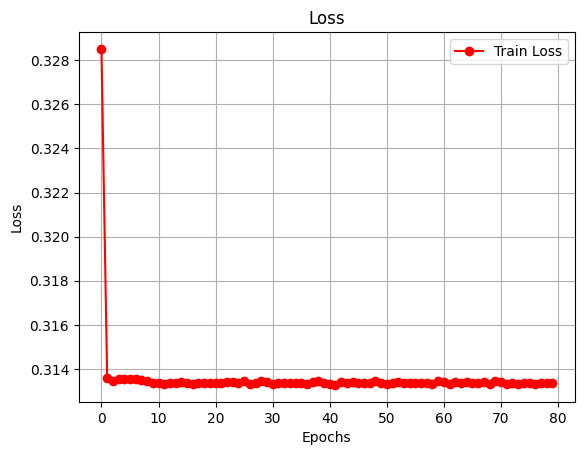

In [24]:
# Loss
plt.plot(epochs, loss_metric, label="Train Loss", color="red", marker="o")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

In [53]:
loss_metric = np.array(loss_metric)
print(f"Среднее значение loss: {np.mean(loss_metric)}")

0.3135759

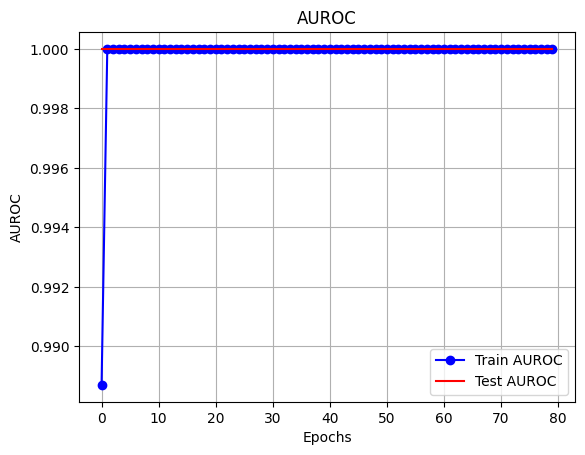

In [37]:
# AUROC
plt.plot(epochs, auroc_train, label="Train AUROC", color="blue", marker="o")
plt.plot(epochs, auroc_test[1::2], label="Test AUROC", color="red")
plt.title("AUROC")
plt.xlabel("Epochs")
plt.ylabel("AUROC")
plt.legend()
plt.grid()
plt.show()

In [54]:
auroc_train = np.array(auroc_train)
print(f"Среднее значение auroc при обучении модели {np.mean(auroc_train)}")
auroc_test = np.array(auroc_test[1::2])
print(f"Среднее значение auroc при тестировании модели {np.mean(auroc_train)}")

Среднее значение auroc при обучении модели 0.9998579291164301
Среднее значение auroc при тестировании модели 0.9998579291164301


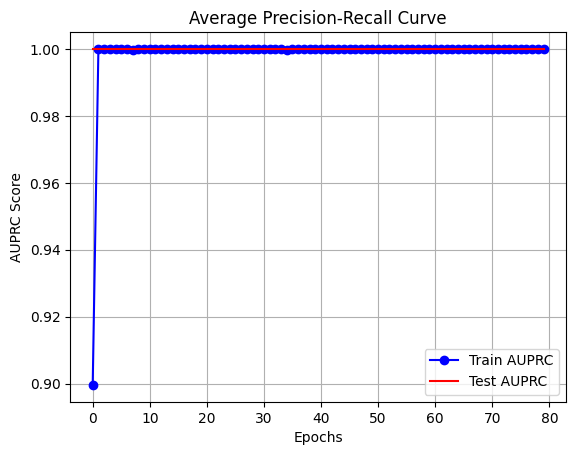

In [51]:
# AUPRC
plt.plot(epochs, auprc_train, label="Train AUPRC", color="blue", marker="o")
plt.plot(epochs, auprc_test[1::2], label="Test AUPRC", color="red")
plt.title("Average Precision-Recall Curve")
plt.xlabel("Epochs")
plt.ylabel("AUPRC Score")
plt.legend()
plt.grid()
plt.show()

In [56]:
auprc_train = np.array(auprc_train)
print(f"Среднее значение Average Precision-Recall Curve при обучении модели {np.mean(auprc_train)}")
auprc_test = np.array(auprc_test[1::2])
print(f"Среднее значение Average Precision-Recall Curve при тестировании модели {np.mean(auprc_test)}")

Среднее значение Average Precision-Recall Curve при обучении модели 0.9987258640233883
Среднее значение Average Precision-Recall Curve при тестировании модели 1.0


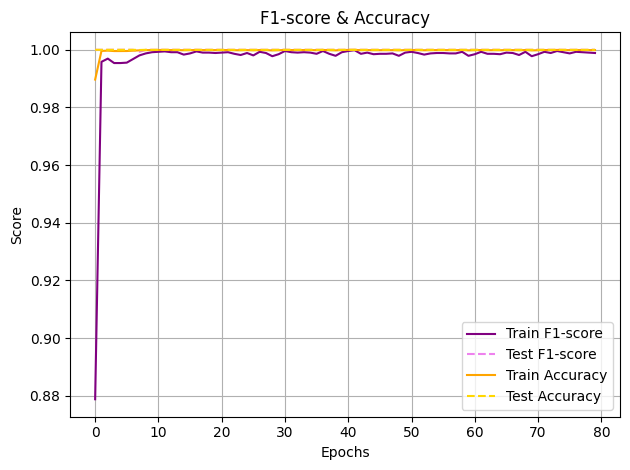

In [50]:
# F1-score & Accuracy
plt.plot(epochs, f1_score_train, label="Train F1-score", color="purple")
plt.plot(epochs, f1_score_test[1::2], label="Test F1-score", color="violet", linestyle="dashed")
plt.plot(epochs, accuracy_train, label="Train Accuracy", color="orange")
plt.plot(epochs, accuracy_test[1::2], label="Test Accuracy", color="gold", linestyle="dashed")
plt.title("F1-score & Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.legend()
plt.grid()

# Отображаем графики
plt.tight_layout()
plt.show()
plt.show()

In [57]:
f1_score_train = np.array(f1_score_train)
print(f"Среднее значение F1 при обучении модели {np.mean(f1_score_train)}")
f1_score_test = np.array(f1_score_test[1::2])
print(f"Среднее значение F1 при тестировании модели {np.mean(f1_score_test)}")

Среднее значение F1 при обучении модели 0.9971389291910177
Среднее значение F1 при тестировании модели 0.9999913374913374


In [58]:
accuracy_train = np.array(accuracy_train)
print(f"Среднее значение Accuracy при обучении модели {np.mean(accuracy_train)}")
accuracy_test = np.array(accuracy_test[1::2])
print(f"Среднее значение Accuracy при тестировании модели {np.mean(accuracy_test)}")

Среднее значение Accuracy при обучении модели 0.9997429327106996
Среднее значение Accuracy при тестировании модели 0.9999991760052737
